# Digital Earth Pacific mineral resource detection using Clay

This notebook applies the Clay model on imagery composites, specifically a Sentinel-2
Geometric Median [(GeoMAD)](https://docs.digitalearthafrica.org/en/latest/data_specs/GeoMAD_specs.html)
and Sentinel-1 mean composite. We will use
[Digital Earth Pacific's STAC API](https://stac-browser.staging.digitalearthpacific.org)
to obtain these datasets, and apply it on a mineral resource detection downstream task
on two levels:

1. Coarse level (chip of size 5.12km x 5.12km) - Using embeddings to get a general
semantic picture
2. Fine level (pixel of size 10m x 10m) - Using a fine-tuned decoder head to get
pixel-level segmentation masks

References:
- https://github.com/digitalearthpacific/mineral-resource-detection
- https://github.com/Clay-foundation/model/discussions/140

In [ ]:
cd ../

In [ ]:
import geopandas as gpd
import pystac_client
import shapely
import stackstac
import torch
import matplotlib.pyplot as plt
import numpy
import pandas as pd
import xarray as xr
import rasterio
import rioxarray  # noqa: F401
import pyarrow as pa
from pathlib import Path
import pickle
import lancedb
import glob
from rasterio.enums import Resampling
from src.datamodule import ClayDataModule
from src.model_clay import CLAYModule

BAND_GROUPS = {
    "rgb": ["B04", "B03", "B02"],
    "rededge": ["B05", "B06", "B07", "B8A"],
    "nir": ["B08"],
    "swir": ["B11", "B12"],
    "sar": ["mean_vv", "mean_vh"],
}

STAC_API = "https://stac.staging.digitalearthpacific.org"
COLLECTION = "dep_s2_geomad"

## Find Sentinel-2 and Sentinel-1 composites stored as Cloud-Optimized GeoTIFFs

Define spatiotemporal query

In [3]:
# bbox for Viti Levu (the Fiji main island) is [177.2, -18.4, 178.9, -17.2]

In [4]:
# Define area of interest
area_of_interest = shapely.box(xmin=177.2, ymin=-18.4, xmax=178.9, ymax=-17.2)

# Define temporal range
daterange: dict = ["2021-01-01T00:00:00Z", "2021-12-31T23:59:59Z"]

In [5]:
catalog = pystac_client.Client.open(url=STAC_API)

sen2_search = catalog.search(
    collections=[COLLECTION],
    datetime=daterange,
    intersects=area_of_interest,
    max_items=100,
)

items = sen2_search.get_all_items()

print(f"Found {len(items)} items")

Found 6 items


/opt/conda/envs/pytorch_custom/lib/python3.10/site-packages/pystac_client/item_search.py:850: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(


## Download the data
Get the data into a numpy array and visualize the imagery. STAC browser URL is at
https://stac-browser.staging.digitalearthpacific.org

/opt/conda/envs/pytorch_custom/lib/python3.10/site-packages/stackstac/prepare.py:408: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(


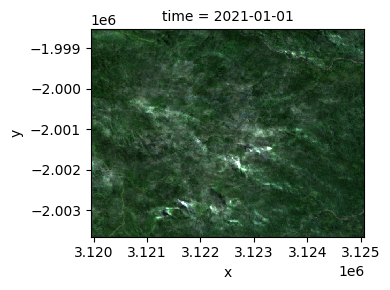

In [6]:
# Extract coordinate system from first item
epsg = items[0].properties["proj:epsg"]

# Convert point from lon/lat to UTM projection
poidf = gpd.GeoDataFrame(crs="OGC:CRS84", geometry=[area_of_interest.centroid]).to_crs(
    epsg
)
geom = poidf.iloc[0].geometry

# Create bounds of the correct size, the model
# requires 512x512 pixels at 10m resolution.
bounds = (geom.x - 2560, geom.y - 2560, geom.x + 2560, geom.y + 2560)

# Retrieve the pixel values, for the bounding box in
# the target projection. In this example we use only
# the RGB and NIR band groups.
stack = stackstac.stack(
    items,
    bounds=bounds,
    snap_bounds=False,
    epsg=epsg,
    resolution=10,
    dtype="float32",
    rescale=False,
    fill_value=0,
    assets=BAND_GROUPS["rgb"] + BAND_GROUPS["nir"],
    resampling=Resampling.nearest,
)

stack = stack.compute()
assert stack.shape == (1, 4, 512, 512)

stack.sel(band=["B04", "B03", "B02"]).plot.imshow(
    row="time", rgb="band", vmin=0, vmax=2000
)

### Get the geospatial bounds for the 32x32 windows 
(which we will use for the patch bboxes)

In [ ]:
# Define the chunk size for tiling
chunk_size = {'x': 32, 'y': 32}  # Adjust the chunk size as needed

# Tile the data
ds_chunked = stack.chunk(chunk_size)

# Get the dimensions of the data array
dims = ds_chunked.dims

# Get the geospatial information from the original dataset
geo_info = ds_chunked.attrs

# Iterate over the chunks and compute the geospatial bounds for each chunk
chunk_bounds = {}

# Get the geospatial transform and CRS
transform = ds_chunked.attrs['transform']
crs = ds_chunked.attrs['crs']

for x in range((ds_chunked.sizes['x'] // chunk_size['x']) + 1):
    for y in range((ds_chunked.sizes['y'] // chunk_size['y']) + 1):
        # Compute chunk coordinates
        x_start = x * chunk_size['x']
        y_start = y * chunk_size['y']
        x_end = min(x_start + chunk_size['x'], ds_chunked.sizes['x'])
        y_end = min(y_start + chunk_size['y'], ds_chunked.sizes['y'])
        
        # Compute chunk geospatial bounds
        lon_start, lat_start = transform * (x_start, y_start)
        lon_end, lat_end = transform * (x_end, y_end)
        print(lon_start, lat_start, lon_end, lat_end, x, y)

        # Store chunk bounds
        chunk_bounds[(x, y)] = {
            'lon_start': lon_start, 'lat_start': lat_start,
            'lon_end': lon_end, 'lat_end': lat_end
        }

# Print chunk bounds
#for key, value in chunk_bounds.items():
    #print(f"Chunk {key}: {value}")



In [8]:
outdir = Path("data/minicubes")
outdir.mkdir(exist_ok=True, parents=True)

write = False
if write:
    # Write tile to output dir
    for tile in stack:
        date = str(tile.time.values)[:10]
    
        name = "{dir}/claytile_{date}.tif".format(
            dir=outdir,
            date=date.replace("-", ""),
        )
        tile.rio.to_raster(name, compress="deflate")
    
        with rasterio.open(name, "r+") as rst:
            rst.update_tags(date=date)


### Generate embeddings for the full or partial inputs
We will generate and save patch level embeddings averaged over the band groups.

In [ ]:
DATA_DIR = "data/minicubes"
CKPT_PATH = "/home/ubuntu/data/checkpoints/mae_epoch-24_val-loss-0.46.ckpt"

# Load model
multi_model = CLAYModule.load_from_checkpoint(
    CKPT_PATH,
    mask_ratio=0.0,
    band_groups={"rgb": (2, 1, 0), "nir": (3,)},
    bands=4,
    strict=False,  # ignore the extra parameters in the checkpoint
    embeddings_level="group",
)
# Set the model to evaluation mode
multi_model.eval()


# Load the datamodule, with the reduced set of
class ClayDataModuleMulti(ClayDataModule):
    MEAN = [
        1369.03,  # red
        1597.68,  # green
        1741.10,  # blue
        2893.86,  # nir
    ]
    STD = [
        2026.96,  # red
        2011.88,  # green
        2146.35,  # blue
        1917.12,  # nir
    ]


data_dir = Path(DATA_DIR)

dm = ClayDataModuleMulti(data_dir=str(data_dir.absolute()), batch_size=1)
dm.setup(stage="predict")
trn_dl = iter(dm.predict_dataloader())

In [ ]:
embeddings = []
for batch in trn_dl:
    with torch.no_grad():
        # Move data from to the device of model
        batch["pixels"] = batch["pixels"].to(multi_model.device)
        # Pass just the specific band through the model
        batch["timestep"] = batch["timestep"].to(multi_model.device)
        batch["latlon"] = batch["latlon"].to(multi_model.device)

        # Pass pixels, latlon, timestep through the encoder to create encoded patches
        (
            unmasked_patches,
            unmasked_indices,
            masked_indices,
            masked_matrix,
        ) = multi_model.model.encoder(batch)
        print(unmasked_patches.detach().cpu().numpy())

        embeddings.append(unmasked_patches.detach().cpu().numpy())

In [11]:
print(len(embeddings[0])) # embeddings is a list
print(embeddings[0].shape) # with date and lat/lon
print(embeddings[0][:, :-2, :].shape) # remove date and lat/lon

1
(1, 514, 768)
(1, 512, 768)


In [12]:
# remove date and lat/lon and reshape to disaggregated patches
embeddings_patch = embeddings[0][:, :-2, :].reshape([2,16,16,768]) 

In [13]:
embeddings_patch.shape

(2, 16, 16, 768)

In [14]:
# average over the band groups
embeddings_patch_avg_group = embeddings_patch.mean(axis=0)

In [15]:
embeddings_patch_avg_group.shape

(16, 16, 768)

In [132]:
# Iterate through each patch
for i in range(embeddings_patch_avg_group.shape[0]):
    for j in range(embeddings_patch_avg_group.shape[1]):
        embeddings_output_patch = embeddings_patch_avg_group[i, j]

        item_ = [element for element in list(chunk_bounds.items()) if element[0] == (i,j)]
        box_ = [item_[0][1]['lon_start'], item_[0][1]['lat_start'],item_[0][1]['lon_end'], item_[0][1]['lat_end']]
        source_url = batch["source_url"]
        date = batch["date"]
        data = {
            "source_url": batch["source_url"][0],
            "date": pd.to_datetime(arg=date, format="%Y-%m-%d").astype(dtype="date32[day][pyarrow]"),
            "embeddings": [numpy.ascontiguousarray(embeddings_output_patch)]
        }
        
        # Define the bounding box as a Polygon (xmin, ymin, xmax, ymax)
        # The box_ list is encoded as [bottom left x, bottom left y, top right x, top right y]
        box = shapely.geometry.box(box_[0], box_[1], box_[2], box_[3])
        
        # Create the GeoDataFrame
        gdf = gpd.GeoDataFrame(data, geometry=[box], crs=f"EPSG:{epsg}")
        
        # Reproject to WGS84 (lon/lat coordinates)
        gdf = gdf.to_crs(epsg=4326)

        outpath = f"data/embeddings/{batch['source_url'][0].split('/')[-1][:-4]}_{i}_{j}.gpq"
        print(outpath)
        gdf.to_parquet(path=outpath, compression="ZSTD", schema_version="1.0.0")
        print(
            f"Saved {len(gdf)} rows of embeddings of "
            f"shape {gdf.embeddings.iloc[0].shape} to {outpath}"
        )

data/embeddings/claytile_20210101_0_0.gpq
Saved 1 rows of embeddings of shape (768,) to data/embeddings/claytile_20210101_0_0.gpq
data/embeddings/claytile_20210101_0_1.gpq
Saved 1 rows of embeddings of shape (768,) to data/embeddings/claytile_20210101_0_1.gpq
data/embeddings/claytile_20210101_0_2.gpq
Saved 1 rows of embeddings of shape (768,) to data/embeddings/claytile_20210101_0_2.gpq
data/embeddings/claytile_20210101_0_3.gpq
Saved 1 rows of embeddings of shape (768,) to data/embeddings/claytile_20210101_0_3.gpq
data/embeddings/claytile_20210101_0_4.gpq
Saved 1 rows of embeddings of shape (768,) to data/embeddings/claytile_20210101_0_4.gpq
data/embeddings/claytile_20210101_0_5.gpq
Saved 1 rows of embeddings of shape (768,) to data/embeddings/claytile_20210101_0_5.gpq
data/embeddings/claytile_20210101_0_6.gpq
Saved 1 rows of embeddings of shape (768,) to data/embeddings/claytile_20210101_0_6.gpq
data/embeddings/claytile_20210101_0_7.gpq
Saved 1 rows of embeddings of shape (768,) to da

In [133]:
ls data/embeddings

claytile_20210101_0_0.gpq    claytile_20210101_2_0.gpq
claytile_20210101_0_1.gpq    claytile_20210101_2_1.gpq
claytile_20210101_0_10.gpq   claytile_20210101_2_10.gpq
claytile_20210101_0_11.gpq   claytile_20210101_2_11.gpq
claytile_20210101_0_12.gpq   claytile_20210101_2_12.gpq
claytile_20210101_0_13.gpq   claytile_20210101_2_13.gpq
claytile_20210101_0_14.gpq   claytile_20210101_2_14.gpq
claytile_20210101_0_15.gpq   claytile_20210101_2_15.gpq
claytile_20210101_0_2.gpq    claytile_20210101_2_2.gpq
claytile_20210101_0_3.gpq    claytile_20210101_2_3.gpq
claytile_20210101_0_4.gpq    claytile_20210101_2_4.gpq
claytile_20210101_0_5.gpq    claytile_20210101_2_5.gpq
claytile_20210101_0_6.gpq    claytile_20210101_2_6.gpq
claytile_20210101_0_7.gpq    claytile_20210101_2_7.gpq
claytile_20210101_0_8.gpq    claytile_20210101_2_8.gpq
claytile_20210101_0_9.gpq    claytile_20210101_2_9.gpq
claytile_20210101_10_0.gpq   claytile_20210101_3_0.gpq
claytile_20210101_10_1.gpq   claytile_20210101_3_1.gpq
clay

In [78]:
gdf = gpd.read_parquet('data/embeddings/claytile_20210101_0_6.gpq')

In [79]:
gdf

,source_url,date,embeddings,geometry
0,/home/ubuntu/dep/model/data/minicubes/claytile...,2021-01-01,"[0.0011603723, 0.030477127, -0.008204196, 0.00...","POLYGON ((178.02988 -17.79449, 178.02988 -17.7..."


In [80]:
gdf.geometry

0    POLYGON ((178.02988 -17.79449, 178.02988 -17.7...
Name: geometry, dtype: geometry

### Similarity search on the patch embedding level

In [57]:
db = lancedb.connect("embeddings")

In [58]:
data = []
for emb in glob.glob("data/embeddings/*.gpq"):
    gdf = gpd.read_parquet(emb)
    gdf["year"] = gdf.date.dt.year
    gdf["tile"] = gdf["source_url"].apply(lambda x: Path(x).stem.rsplit("/")[-1].rsplit("_")[0])
    gdf["idx"] = '_'.join(emb.split("/")[-1].split("_")[2:]).replace('.gpq', '')
    
    for _,row in gdf.iterrows():
        data.append({
            "vector": row["embeddings"],
            "path": row["source_url"],
            "tile": row["tile"],
            "date": row["date"],
            "year": int(row["year"]),
            "idx": row["idx"],
        })

In [62]:
#db.drop_table("clay-v001")
db.table_names()

['clay-v001']

In [61]:
tbl = db.create_table("clay-v001", data=data, mode="overwrite")

[2024-03-08T18:19:08Z WARN  lance::dataset] No existing dataset at /home/ubuntu/dep/model/embeddings/clay-v001.lance, it will be created


In [63]:
v = tbl.head(1).to_pandas()["vector"].values[0]

In [64]:
result = tbl.search(query=v).limit(10).to_pandas()

In [65]:
result.head(10)

,vector,path,tile,date,year,idx,_distance
0,"[0.0013022188, 0.015624791, 0.010995232, 0.044...",/home/ubuntu/dep/model/data/minicubes/claytile...,claytile,2021-01-01,2021,10_10,0.000000
1,"[0.004593527, 0.009543372, 0.0031644334, 0.019...",/home/ubuntu/dep/model/data/minicubes/claytile...,claytile,2021-01-01,2021,2_15,0.264793
2,"[-0.00038168614, -0.0020814952, 0.0060004545, ...",/home/ubuntu/dep/model/data/minicubes/claytile...,claytile,2021-01-01,2021,3_11,0.265933
3,"[-0.00038257916, 0.007975662, 0.0025369425, 0....",/home/ubuntu/dep/model/data/minicubes/claytile...,claytile,2021-01-01,2021,7_3,0.270023
4,"[-0.00073575776, -0.00072236825, 0.0006782048,...",/home/ubuntu/dep/model/data/minicubes/claytile...,claytile,2021-01-01,2021,9_11,0.274544
5,"[0.0051200716, 0.027311623, 0.009802145, 0.022...",/home/ubuntu/dep/model/data/minicubes/claytile...,claytile,2021-01-01,2021,12_8,0.295159
6,"[0.0046385187, 0.035278495, 0.0047687287, 0.04...",/home/ubuntu/dep/model/data/minicubes/claytile...,claytile,2021-01-01,2021,13_2,0.306697
7,"[0.004657602, 0.0065579414, -0.004084409, 0.01...",/home/ubuntu/dep/model/data/minicubes/claytile...,claytile,2021-01-01,2021,14_13,0.307831
8,"[0.0015290881, 0.0036308402, -0.0044799456, 0....",/home/ubuntu/dep/model/data/minicubes/claytile...,claytile,2021-01-01,2021,11_12,0.309238
9,"[0.004930552, 0.03984072, 0.003469127, 0.03263...",/home/ubuntu/dep/model/data/minicubes/claytile...,claytile,2021-01-01,2021,7_2,0.314782


### Plot similar patches

In [116]:
def plot(df, cols=10):
    fig, axs = plt.subplots(1, cols, figsize=(20, 10))

    row_0 = df.iloc[0]
    path = row_0["path"]
    chip = rasterio.open(path)
    tile = row_0["tile"]
    width = chip.width
    height = chip.height
    # Define the window size
    window_size = (32, 32)

    idxs_windows = {'idx': [], 'window': []}

    # Iterate over the image in 32x32 windows
    for col in range(0, width, window_size[0]):
        for row in range(0, height, window_size[1]):
            # Define the window
            window = ((row, row + window_size[1]), (col, col + window_size[0]))
            
            # Read the data within the window
            data = chip.read(window=window)
            
            # Get the index of the window
            index = (col // window_size[0], row // window_size[1])
            
            # Process the window data here
            # For example, print the index and the shape of the window data
            #print("Index:", index)
            #print("Window Shape:", data.shape)

            idxs_windows['idx'].append('_'.join(map(str, index)))
            idxs_windows['window'].append(data)
            
    #print(idxs_windows)
    
    for ax, (_, row) in zip(axs.flatten(), df.iterrows()):
        idx = row["idx"]
        # Find the corresponding window based on the idx
        window_index = idxs_windows['idx'].index(idx)
        window_data = idxs_windows['window'][window_index]
        print(window_data.shape)
        subset_img = numpy.clip((window_data.transpose(1,2,0)[:, :, :3]/10_000) * 3, 0,1)
        ax.imshow(subset_img)
        ax.set_title(f"{tile}/{idx}")
        ax.set_axis_off()
    plt.tight_layout()
    fig.savefig("similar.png")

(4, 32, 32)
(4, 32, 32)
(4, 32, 32)
(4, 32, 32)
(4, 32, 32)
(4, 32, 32)
(4, 32, 32)
(4, 32, 32)
(4, 32, 32)
(4, 32, 32)


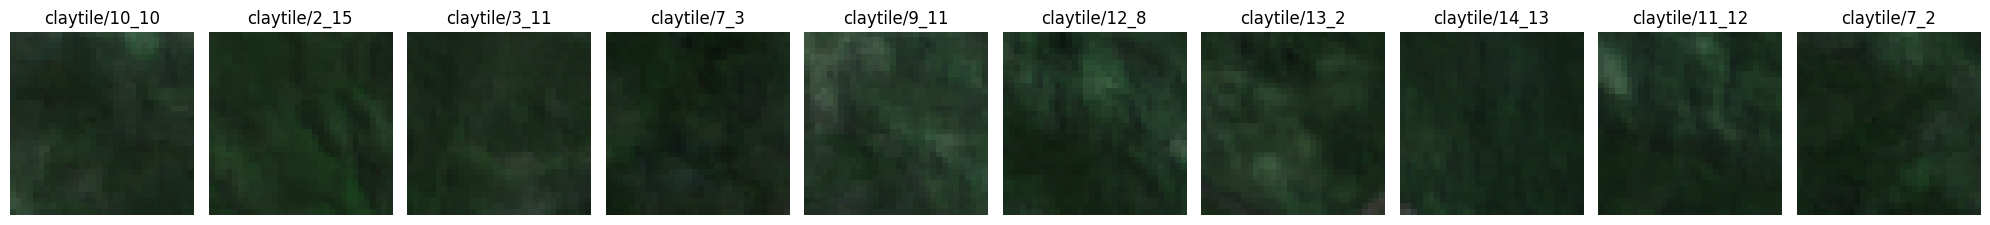

In [117]:
plot(result)

In [74]:
chips = [
    {"tile": "claytile", "idx": "10_10", "year": 2021},
    {"tile": "claytile", "idx": "1_1", "year": 2021},
    {"tile": "claytile", "idx": "3_3", "year": 2021},
]
filter = " OR ".join(
        [f"(tile == '{chip['tile']}' AND idx == '{chip['idx']}') AND year == {chip['year']}" for chip in chips]
    )

v = tbl.search().where(filter).to_pandas().iloc[0]["vector"]

In [75]:
tbl.search().where(filter).to_pandas()

,vector,path,tile,date,year,idx
0,"[0.0013022188, 0.015624791, 0.010995232, 0.044...",/home/ubuntu/dep/model/data/minicubes/claytile...,claytile,2021-01-01,2021,10_10
1,"[0.003363898, 0.024073904, 0.00014781719, 0.00...",/home/ubuntu/dep/model/data/minicubes/claytile...,claytile,2021-01-01,2021,3_3
2,"[0.0042217607, 0.038776778, 0.002145402, 0.029...",/home/ubuntu/dep/model/data/minicubes/claytile...,claytile,2021-01-01,2021,1_1


In [76]:
v

array([ 1.30221876e-03,  1.56247914e-02,  1.09952316e-02,  4.41329181e-02,
       -5.28868567e-03, -5.66805862e-02, -1.63438246e-02,  5.12235891e-03,
       -3.98675445e-03, -7.80126899e-02, -6.95531368e-02, -4.98436213e-01,
       -9.19451844e-03, -1.94345973e-02,  1.36392508e-02, -5.02116326e-03,
        2.25299690e-02, -2.17332412e-03,  2.45579965e-02,  2.55101034e-03,
        2.48161778e-02,  2.36984007e-02, -1.19083130e-03,  4.26745415e-03,
       -4.72431164e-03,  5.12825139e-02,  6.07860871e-02,  1.75897162e-02,
        4.50184755e-03, -1.28481793e-03,  1.02878045e-02, -1.01807052e-02,
       -3.08134630e-02,  3.76995420e-03, -1.85567979e-03, -6.90264069e-03,
       -3.97070218e-03,  4.73083113e-04,  1.44641828e-02,  8.43156129e-04,
       -2.29678415e-02,  3.41908261e-02,  1.46035179e-02,  7.12811574e-03,
       -2.30457298e-02, -1.02587687e-02, -1.68103296e-02,  4.68257396e-03,
        1.47755258e-04, -1.24446526e-02, -9.82742105e-03, -2.05345489e-02,
        2.31024269e-02, -

### Read the mining extraction ground truth points
We will use these for reference in a similarity search.

In [ ]:
mrd = gpd.read_file("../mineral-resource-detection/training_data/draft_inputs/MRD_dissagregated_25.geojson")

In [23]:
mrd

,fid,index,id,x,y,lulc_code,lulc_class,layer,path,geometry
0,1,1,1,177.58868306261775,-17.726528354679946,2,forest,MRD_dissagregated_20,X:\MRD_Dev\Labelled data\Training data\MRD_dis...,POINT (177.58868 -17.72653)
1,2,2,2,177.5899726942678,-17.702139144356817,2,forest,MRD_dissagregated_20,X:\MRD_Dev\Labelled data\Training data\MRD_dis...,POINT (177.58997 -17.70214)
2,3,3,3,177.5584999924552,-17.696312095467405,2,forest,MRD_dissagregated_20,X:\MRD_Dev\Labelled data\Training data\MRD_dis...,POINT (177.55850 -17.69631)
3,4,4,4,177.56227406154886,-17.800601572580046,2,forest,MRD_dissagregated_20,X:\MRD_Dev\Labelled data\Training data\MRD_dis...,POINT (177.56227 -17.80060)
4,5,5,5,177.59011967434577,-17.825061902295637,2,forest,MRD_dissagregated_20,X:\MRD_Dev\Labelled data\Training data\MRD_dis...,POINT (177.59012 -17.82506)
...,...,...,...,...,...,...,...,...,...,...
1324,1325,1325,1325,177.7727323559106,-17.718567990643447,8,quarry,None,None,POINT (177.77273 -17.71857)
1325,1326,1326,1326,177.73552354739425,-17.611927940311453,1,bare_land,None,None,POINT (177.73552 -17.61193)
1326,1327,1327,1327,177.66355091159068,-17.51703115347686,8,quarry,None,None,POINT (177.66355 -17.51703)
1327,1328,1328,1328,177.66404662393933,-17.516119249528824,8,quarry,None,None,POINT (177.66405 -17.51612)


In [24]:
mrd.lulc_class.unique()

array(['forest', 'grassland', 'bare_land', 'crops', 'quarry', 'water',
       'settlements', 'mangroves'], dtype=object)

In [25]:
mrd.crs.to_epsg()

4326

In [26]:
epsg

3832

In [27]:
mrd = mrd.to_crs(epsg)

In [28]:
mrd.crs.to_epsg()

3832